# Exercise 01: The First Step with PyTorch

In this exercise, you will learn how to explore data with the commonly used library – PyTorch.
You will conduct several simple analyses and visualizations on the CIFAR-10 dataset, which is
a popular dataset for multi-class classification.

In [1]:
from imbalance_data.cifar10Imbanlance import Cifar10Imbanlance
import warnings
warnings.filterwarnings("ignore")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

## Imbanlanced CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The CIFAR10-LT is a long-tailed version of the CIFAR-10 dataset, where some classes have a
disproportionately higher number of instances than others. There we will generate an long-tailed dataset from CIFAR-10 by ``Cifar10Imbanlance`` class.

Generate an imbanlanced dataset 

In [2]:
imbanlance_rate = 0.1
# the dataset directory
root = "/shareddata/"
trainset = Cifar10Imbanlance(imbanlance_rate, transform=transforms.ToTensor(), train=True, file_path=root)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)


Files already downloaded and verified


Labels of Cifar10 are below.

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

There we define a function called ``plot_cifar10``, which can plot ten pictures from a given batch.

In [4]:

def plot_cifar10(images,labels):
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        image = images[i].numpy()
        label = labels[i].item()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(class_names[label])
        plt.axis('off')

    plt.show()

Plot CIFAR-10 data set images and corresponding labels.

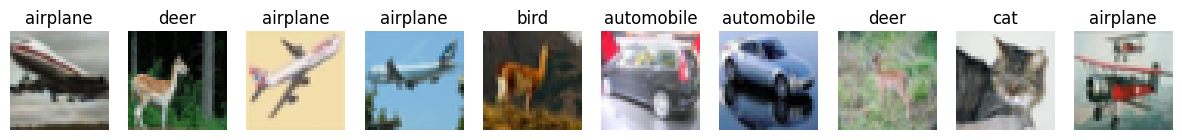

In [5]:
# Creat an iterator object `dataiter` from the `train_dataloader`
# then use the `next()` function to get the next batch of images and labels from the iterator. 
# This allows us to access the data in batches for training or evaluation purposes.
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
plot_cifar10(images,labels)

## Exercise

---

### Task 1: class prior estimation
Please denfine a function named ``count_class_instances`` that takes a dataloader as input and obtains the **sample size of each class** in this
dataset. It returns a tensor containing the count of each class.

In [6]:
def count_class_instances(train_dataloader):
    # write your code there
    
    # The output of the function should be a tensor that contains the sample size of each class.
    # class_counts is an tensors with shape torch.Size([10])
    category_counts = {}  
    data_iter = iter(train_dataloader)
    for images, lables in data_iter:  
        for lable in labels:
            category = lable.item()
            if category not in category_counts:
                category_counts[category] = 1
            else:
                category_counts[category] += 1  
  
    class_counts = torch.Tensor([category_counts[category] for category in category_counts.keys()])  
  
    return class_counts

Then we calculate and display the number of samples or instances for each class using the ``count_class_instances`` function. 

In [7]:
class_counts = count_class_instances(train_dataloader)

for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {int(count)} samples")

airplane: 5600 samples
automobile: 1120 samples
bird: 2080 samples
cat: 4160 samples
deer: 2560 samples
dog: 1600 samples
frog: 960 samples
horse: 1280 samples
ship: 320 samples
truck: 800 samples


---
### Task 2: dataset statistics calculation

Please denfine a function named ``compute_channel_mean_std``, which iscalculates the channel-wise mean (mu, $\mu$) and standard deviation (std, $\sigma$). It takes a dataloader as input.



In [8]:
def compute_channel_mean_std(train_dataloader):
    # write your code there
    
    # The outputs of the function should be two tensors: mu and std, which contain three values corresponding to the three channels.
    # channel_means, channel_stddevs are tensors with shape torch.Size([3])  
    # 初始化均值和标准差的字典，键是通道名称，值是0  
    channel_stats = {'mean': {'red': 0, 'green': 0, 'blue': 0}, 'std': {'red': 0, 'green': 0, 'blue': 0}}  
    data_iter = iter(train_dataloader)
    # 遍历所有图像  
    for images, lables in data_iter:  
        # 将图像分解为三个通道
        for image in images:
            red, green, blue = torch.unbind(image, dim=0)  

            # 计算每个通道的均值和标准差  
            channel_stats['mean']['red'] += red.mean()  
            channel_stats['mean']['green'] += green.mean()  
            channel_stats['mean']['blue'] += blue.mean()  

            channel_stats['std']['red'] += red.std()  
            channel_stats['std']['green'] += green.std()  
            channel_stats['std']['blue'] += blue.std()  
  
    # 计算整个数据集的均值和标准差  
    channel_stats['mean']['red'] /= len(images)  
    channel_stats['mean']['green'] /= len(images)  
    channel_stats['mean']['blue'] /= len(images)  
  
    channel_stats['std']['red'] = torch.sqrt(channel_stats['std']['red'] / len(images))  
    channel_stats['std']['green'] = torch.sqrt(channel_stats['std']['green'] / len(images))  
    channel_stats['std']['blue'] = torch.sqrt(channel_stats['std']['blue'] / len(images))  
  
    # 将结果转换为张量并返回  
    mu = torch.tensor([channel_stats['mean']['red'], channel_stats['mean']['green'], channel_stats['mean']['blue']])  
    std = torch.tensor([channel_stats['std']['red'], channel_stats['std']['green'], channel_stats['std']['blue']])  
  
    return mu, std
    return channel_means, channel_stddevs

There we print means and deviations for each channels.

In [9]:
channel_means, channel_stddevs = compute_channel_mean_std(train_dataloader)
print("Channel means:", channel_means)
print("Channel standard deviations:", channel_stddevs)

Channel means: tensor([128.0698, 127.1252, 120.2381])
Channel standard deviations: tensor([7.1728, 7.1132, 7.1697])


Then we plot normalized images with corresponding labels.

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

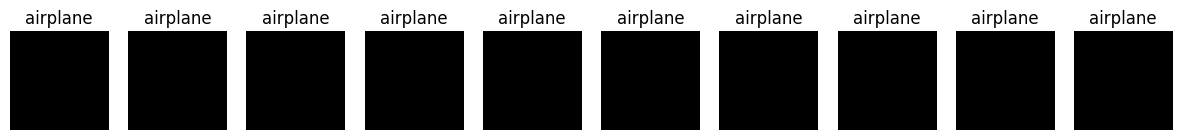

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = channel_means, std = channel_stddevs)])
trainset_normalize = Cifar10Imbanlance(imbanlance_rate, transform=transform, train=True, file_path=root)
train_normalize_dataloader = torch.utils.data.DataLoader(trainset_normalize, batch_size=128, shuffle=False)
dataiter = iter(train_normalize_dataloader)
images, labels = next(dataiter)
plot_cifar10(images,labels)